In [2]:
# Re-import necessary libraries and re-load the dataset
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import export_text
import joblib
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Re-load the dataset
df = pd.read_csv('../data/bb_results.csv')
df.head()

,Sex,Single,Unemployed,Age,Credit,LoanDuration,PurposeOfLoan,InstallmentRate,Housing,Label,Prediction,BinaryPrediction
0,1.0,1,0,67,1169,6,3,4,1.0,1,0.994458,1
1,0.0,0,0,22,5951,48,3,2,1.0,0,0.689426,1
2,1.0,1,0,49,2096,12,2,2,1.0,1,0.977333,1
3,1.0,1,0,45,7882,42,4,2,3.0,1,0.814685,1
4,1.0,1,0,53,4870,24,6,3,3.0,0,0.507499,1


In [4]:
# Re-split the dataset
X = df.drop(['Label', 'Prediction', 'BinaryPrediction'], axis=1)
y = df['BinaryPrediction']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define and train the best model again using previously found best hyperparameters
best_params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Save the model
model_path = 'best_decision_tree_model.joblib'
joblib.dump(best_model, model_path)

# Predict on the validation set
y_pred_validate = best_model.predict(X_validate)

# Combine real and predicted labels for comparison
results_validate = pd.DataFrame({
    'Real Label': y_validate,
    'Predicted Label': y_pred_validate
})

print(results_validate.head())

     Real Label  Predicted Label
824           1                1
587           1                1
499           1                1
65            1                1
218           0                1


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Calculate the accuracy of the model
accuracy = accuracy_score(y_validate, y_pred_validate)
print(f"Accuracy: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_validate, y_pred_validate)
print(conf_matrix)

Accuracy: 0.83
[[ 22  18]
 [ 15 145]]


In [5]:
# Extract the structure of the decision tree
tree_structure = export_text(best_model)
print(tree_structure)


|--- feature_8 <= 1.50
|   |--- feature_4 <= 7834.50
|   |   |--- feature_5 <= 11.50
|   |   |   |--- class: 1
|   |   |--- feature_5 >  11.50
|   |   |   |--- feature_1 <= 0.50
|   |   |   |   |--- feature_6 <= 4.50
|   |   |   |   |   |--- feature_2 <= 0.50
|   |   |   |   |   |   |--- feature_4 <= 2801.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_4 >  2801.00
|   |   |   |   |   |   |   |--- feature_4 <= 3003.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_4 >  3003.50
|   |   |   |   |   |   |   |   |--- feature_4 <= 3859.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_4 >  3859.00
|   |   |   |   |   |   |   |   |   |--- feature_4 <= 4067.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_4 >  4067.50
|   |   |   |   |   |   |   |   |   |   |--- feature_3 <= 26.50
|   |   |   |   |   |   |   |   |   

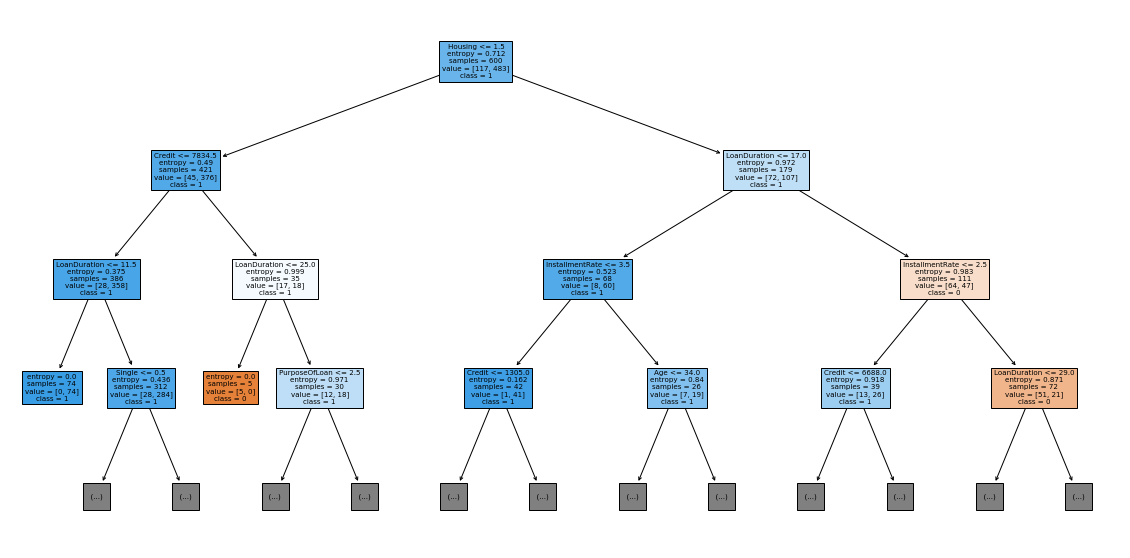

In [6]:
# Plot the structure of the decision tree
plt.figure(figsize=(20,10))
plot_tree(best_model, filled=True, feature_names=["Sex","Single","Unemployed","Age","Credit","LoanDuration","PurposeOfLoan","InstallmentRate","Housing"], class_names=["0", "1"], max_depth=3)
plt.savefig('decision_tree_structure.png')
plt.show()

In [8]:
from sklearn.tree import _tree
# Extract a single instance from the validation set to trace its decision path
instance_index = 0  # Example: first instance in the validation set
single_instance = X_validate.iloc[[instance_index]]

# Use the decision_path method to get the path for this instance
decision_path = best_model.decision_path(single_instance)

# Initialize lists to store the path details
feature_names = single_instance.columns

# Function to get decision path details for a specific instance
def get_decision_path_details(model, single_instance, feature_names):
    # Get the decision path for the instance
    decision_path = model.decision_path(single_instance).indices

    # Lists to hold the path details
    decision_features = []
    decision_thresholds = []
    decision_directions = []

    tree_ = model.tree_

    for node_index in decision_path:
        if tree_.feature[node_index] != _tree.TREE_UNDEFINED:  # Ensure it's not a leaf node
            # Feature name and threshold
            feature_name = feature_names[tree_.feature[node_index]]
            threshold = tree_.threshold[node_index]

            # Decision direction
            if single_instance.iloc[0, tree_.feature[node_index]] <= threshold:
                decision = f"<= {threshold:.2f} (True)"
            else:
                decision = f"> {threshold:.2f} (False)"

            # Append to lists
            decision_features.append(feature_name)
            decision_thresholds.append(threshold)
            decision_directions.append(decision)

    # Create a DataFrame for visualization
    decision_path_df = pd.DataFrame({
        'Feature': decision_features,
        'Threshold': decision_thresholds,
        'Decision': decision_directions
    })

    return decision_path_df

# Correctly call the function with the required parameters
decision_path_df = get_decision_path_details(best_model, single_instance, feature_names)
decision_path_df


,Feature,Threshold,Decision
0,Housing,1.5,<= 1.50 (True)
1,Credit,7834.5,<= 7834.50 (True)
2,LoanDuration,11.5,> 11.50 (False)
3,Single,0.5,<= 0.50 (True)
4,PurposeOfLoan,4.5,<= 4.50 (True)
5,Unemployed,0.5,<= 0.50 (True)
6,Credit,2801.0,> 2801.00 (False)
7,Credit,3003.5,> 3003.50 (False)
8,Credit,3859.0,<= 3859.00 (True)
